$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Fitting an entire year's data, even for just one station's data, is quite time consuming. We're not really interested in long-term correlations (like seasonal components), so it makes sense to divide the data up into smaller chunks (of a few weeks of data). Some information is lost, but I don't think any bias is introduced. If this means we can fit multiple stations' temperature time series, then this is a net win.

In [1]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, update_mll!, evaluate, metric
import GaussianProcesses: cov
import GaussianProcesses: optimize!, get_optim_target
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
using Optim
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
include("iowa.jl")
iowa = prepare_iowa_data(data_dir);

In [4]:
iowa[:isdSubset]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [5]:
usaf=725450
wban=14990
id=1
station_data=iowa[:hourly_data][iowa[:hourly_data][:station] .== 1, :]
DataFrames.head(station_data)

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,2015-01-01T01:00:00,52,0,-7.8,2015-01-01T00:52:00,1,0.866667
2,2015,1,1,2015-01-01T02:00:00,52,0,-8.3,2015-01-01T01:52:00,1,1.86667
3,2015,1,1,2015-01-01T03:00:00,52,0,-8.3,2015-01-01T02:52:00,1,2.86667
4,2015,1,1,2015-01-01T04:00:00,52,0,-9.4,2015-01-01T03:52:00,1,3.86667
5,2015,1,1,2015-01-01T05:00:00,52,0,-9.4,2015-01-01T04:52:00,1,4.86667
6,2015,1,1,2015-01-01T06:00:00,52,0,-10.0,2015-01-01T05:52:00,1,5.86667


# Kernel Specification

In [6]:
k0 = Noise(-1.0)
k1 = fix(Periodic(log(0.5), log(√(10.0)), log(24.0)), :lp)
k2 = RQIso(log(2.0), log(√10.0), 3.0) # short term
k3 = SEIso(log(2.0), log(√10.0)) # short term SE
k4 = RQIso(log(1.0*24), log(√10.0), 3.0)
k5 = RQIso(log(10.0*24), log(√10.0), 3.0)
k6 = SE(log(100.0*24), log(√80.0))
_k=k0+k1+k2+k3+k4+k5
_k_nonoise=k1+k2+k3+k4+k5+k6
_logNoise=log(k0.σ2)/2.0
hyp=[-0.359207,0.36883,1.45171,2.0342,1.17682,2.88579,4.28659,1.49533,-0.16544,6.81425,1.3045,3.49925,7.34764,2.16028]
hyp_nonoise=[-1.49471,9.68156,0.28408,1.04675,-1.18377,-0.886588,-0.0974043,2.6959,2.41763,-3.61659,6.89384,1.18493,3.49553,7.7369,2.4648]
# set_params!(_k, hyp)
# set_params!(_k_nonoise, hyp_nonoise[3:end])
_logNoise=hyp_nonoise[1]
_meanfunc=MeanConst(0.0)
;

# Infrastructure for multiple realizations

In [7]:
ts_vec = station_data[:ts_hours]
temp_vec = station_data[:temp]
;

In [8]:
chunksize=300
istart=1
gprealisations=GPE[]
while istart < length(ts_vec)
    iend = min(istart+chunksize-1, length(ts_vec))
    x = ts_vec[istart:iend]
    y = temp_vec[istart:iend]
    m = MeanConst(mean(y))
    gp = GPE(x', y, m, _k_nonoise, _logNoise);
    push!(gprealisations, gp)
    istart+=chunksize
end

In [9]:
_gpr = TempModel.GPRealisations(gprealisations, _meanfunc, _k_nonoise, _logNoise, 0.0, Float64[]);
TempModel.update_mll!(_gpr)
_gpr.mll

-17244.355249758086

In [10]:
update_mll_and_dmll!(_gpr, domean=false)
@time update_mll_and_dmll!(_gpr, domean=false);
_gpr.dmll

  1.749451 seconds (37.64 k allocations: 2.388 MiB)


16-element Array{Float64,1}:
  7836.03     
   186.719    
  -229.568    
  -515.742    
 -1230.37     
  -139.809    
  1064.14     
 -1457.86     
     3.4704   
    53.0358   
     0.399378 
    -8.99219  
     6.15068  
     0.0253696
    -0.91557  
   -31.2275   

In [11]:
_func = get_optim_target(_gpr, domean=false)

NLSolversBase.OnceDifferentiable{Float64,Array{Float64,1},Array{Float64,1},Val{false}}(TempModel.mll, TempModel.dmll!, TempModel.mll_and_dmll!, 0.0, [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [0], [0])

In [12]:
import Calculus

In [13]:
_x=get_params(_gpr, domean=false)
numgrad = Calculus.gradient(_func.f, _x)

16-element Array{Float64,1}:
 -7836.03     
  -186.719    
   229.567    
   515.742    
  1230.37     
   139.81     
 -1064.14     
  1457.86     
    -3.4705   
   -53.0358   
    -0.399381 
     8.99222  
    -6.15081  
    -0.0251946
     0.915561 
    31.2275   

In [14]:
anlgrad=similar(numgrad) # analytical gradient
_func.df(anlgrad, _x)
anlgrad

16-element Array{Float64,1}:
 -7836.03     
  -186.719    
   229.568    
   515.742    
  1230.37     
   139.809    
 -1064.14     
  1457.86     
    -3.4704   
   -53.0358   
    -0.399378 
     8.99219  
    -6.15068  
    -0.0253696
     0.91557  
    31.2275   

In [15]:
for (i,j) in zip(numgrad,anlgrad)
    @printf("%10.3f %10.3f\n", i, j)
    @assert isapprox(i,j, rtol=1e-4, atol=1e-3)
end

 -7836.034  -7836.034
  -186.719   -186.719
   229.567    229.568
   515.742    515.742
  1230.370   1230.370
   139.810    139.809
 -1064.136  -1064.136
  1457.857   1457.857
    -3.470     -3.470
   -53.036    -53.036
    -0.399     -0.399
     8.992      8.992
    -6.151     -6.151
    -0.025     -0.025
     0.916      0.916
    31.228     31.227


# Optimization

In [16]:
@time opt_out=optimize!(_gpr, domean=false, options=Optim.Options(x_tol=1e-5, f_tol=1e-5));

134.919390 seconds (13.20 M allocations: 527.534 MiB, 0.43% gc time)


In [17]:
opt_out

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.49471,-0.6931471805599453, ...]
 * Minimizer: [-1.466606789002481,-0.06963644984173266, ...]
 * Minimum: 1.248503e+04
 * Iterations: 49
 * Convergence: true
   * |x - x'| ≤ 1.0e-05: false 
     |x - x'| = 3.17e-03 
   * |f(x) - f(x')| ≤ 1.0e-05 |f(x)|: true
     |f(x) - f(x')| = 1.75e-06 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.84e+00 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 110
 * Gradient Calls: 62

In [18]:
print(Optim.minimizer(opt_out))

[-1.46661, -0.0696364, 1.05951, 1.64818, 1.25672, -1.75843, -1.25133, -1.05897, 3.13642, 1.28518, 2.8321, 3.38125, 0.268999, 3.01122, 7.70207, -6.05179]

In [19]:
print(Optim.minimizer(opt_out))

[-1.46661, -0.0696364, 1.05951, 1.64818, 1.25672, -1.75843, -1.25133, -1.05897, 3.13642, 1.28518, 2.8321, 3.38125, 0.268999, 3.01122, 7.70207, -6.05179]

In [20]:
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.kern.σ2)
@printf("l: %5.3f\n", √k1.kern.ℓ2)
@printf("p: %5.0f hours\n", k1.kern.p)
print("\nk₂: RQIso \n=================\n")
@printf("σ: %5.3f\n", √ k2.σ2)
@printf("l: %5.3f hours\n", √ k2.ℓ2)
@printf("α: %5.3f\n", k2.α)
print("\nk₃: SEIso \n=================\n")
@printf("σ: %5.3f\n", √k3.σ2)
@printf("l: %5.3f hours\n", √k3.ℓ2)
print("\nk₄: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k4.σ2)
@printf("l: %5.3f days\n", √k4.ℓ2 / 24)
@printf("α: %5.3f\n",  k4.α)
print("\nk₅: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k5.σ2)
@printf("l: %5.3f days\n", √k5.ℓ2 / 24)
@printf("α: %5.3f\n",  k5.α)
print("\nk₆ SEIso \n=================\n")
@printf("σ: %5.3f\n", √k6.σ2)
@printf("l: %5.3f days\n", √k6.ℓ2 / 24)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(_gpr.logNoise))

k₁: Periodic 
σ: 2.885
l: 0.933
p:    24 hours

k₂: RQIso 
σ: 3.514
l: 5.197 hours
α: 0.172

k₃: SEIso 
σ: 0.347
l: 0.286 hours

k₄: RQIso 
σ: 3.615
l: 0.959 days
α: 16.981

k₅: RQIso 
σ: 1.309
l: 1.225 days
α: 20.312

k₆ SEIso 
σ: 0.002
l: 92.205 days

σy: 0.231


# Visualizing fitted kernel

## Empirical variogram

In [21]:
_bins = collect(0:400*24)
station_variog = TempModel.variog(
    TempModel.timeseries_variogram(ts_vec, temp_vec.-mean(temp_vec), _bins)
    )
;

## Variogram plots

In [22]:
# Assume all components are stationary
function cov(sumkern::SumKernel, r::Float64)
    ck = 0.0
    for k in sumkern.kerns
        ck += cov(k, [r], [0.0])
    end
    return ck
end
;

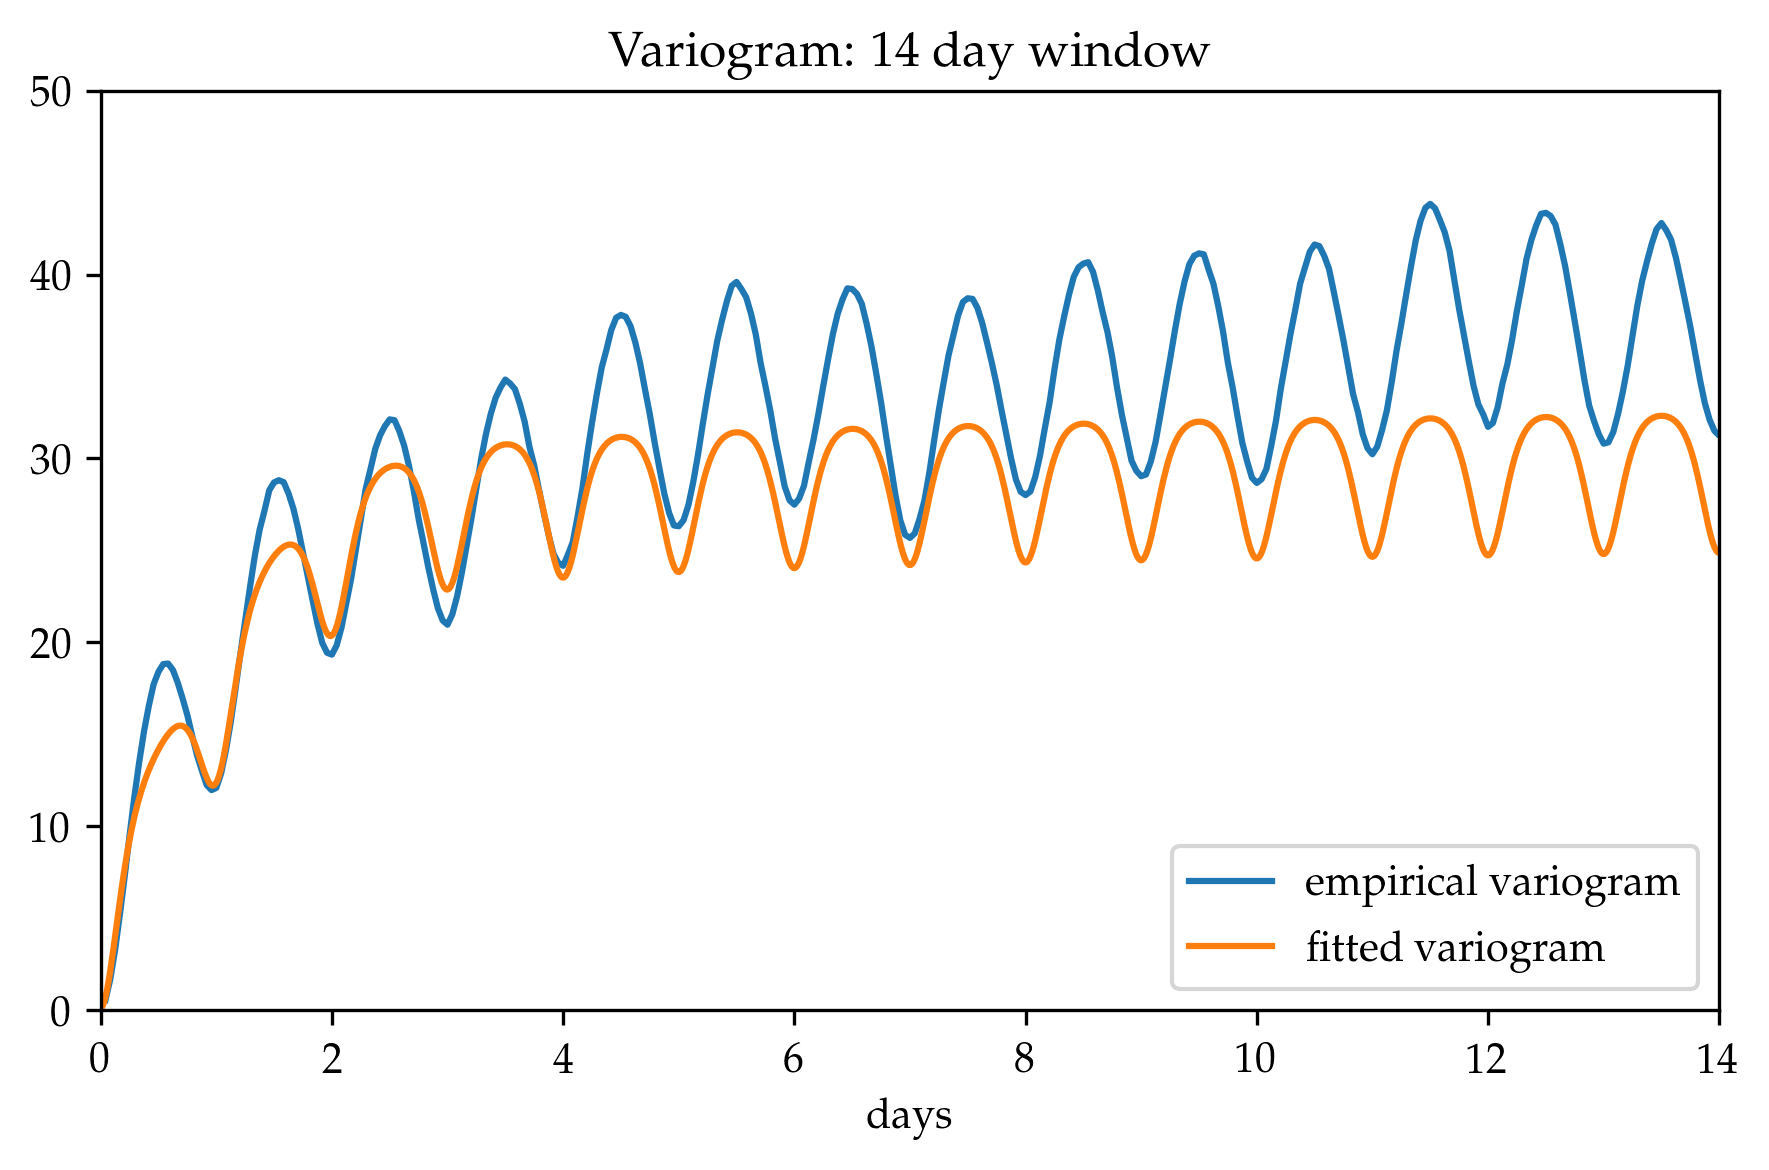

In [23]:
begin
    bins_hours = Float64.(_bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, label="empirical variogram")
    plt.ylim(0,50)
    plt.xlim(0,14)
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24.0, exp(2.0*_gpr.logNoise)+ck_r[1].-ck_r, label="fitted variogram")
    plt.legend(loc="lower right")
    plt.xlabel("days")
    plt.title("Variogram: 14 day window")
end
;

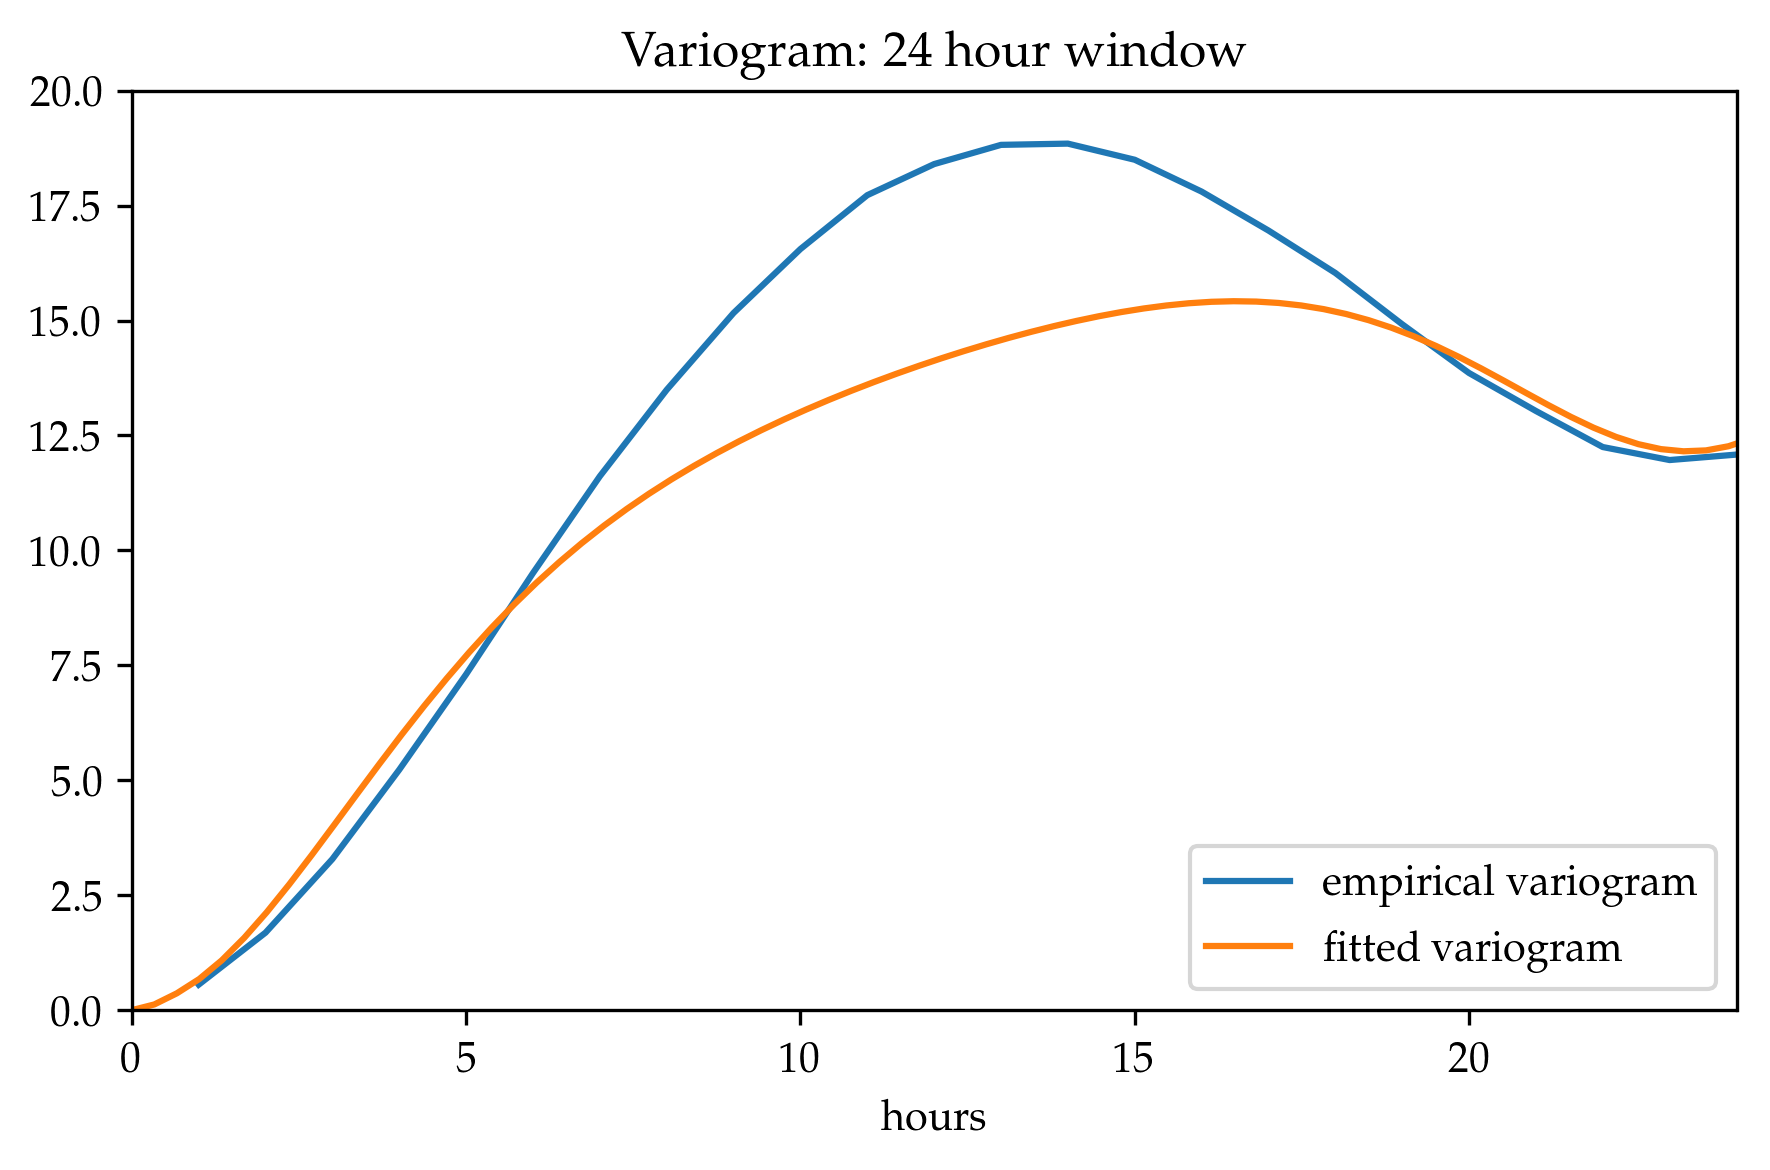

In [24]:
begin
    bins_hours = Float64.(_bins);
    bins_days = bins_hours/24;
    plt.plot(bins_hours, station_variog, label="empirical variogram")
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr, ck_r[1].-ck_r, label="fitted variogram")
    plt.legend(loc="lower right")
    plt.xlabel("hours")
    plt.ylim(0,20)
    plt.xlim(0,24)
    plt.title("Variogram: 24 hour window")
end
;

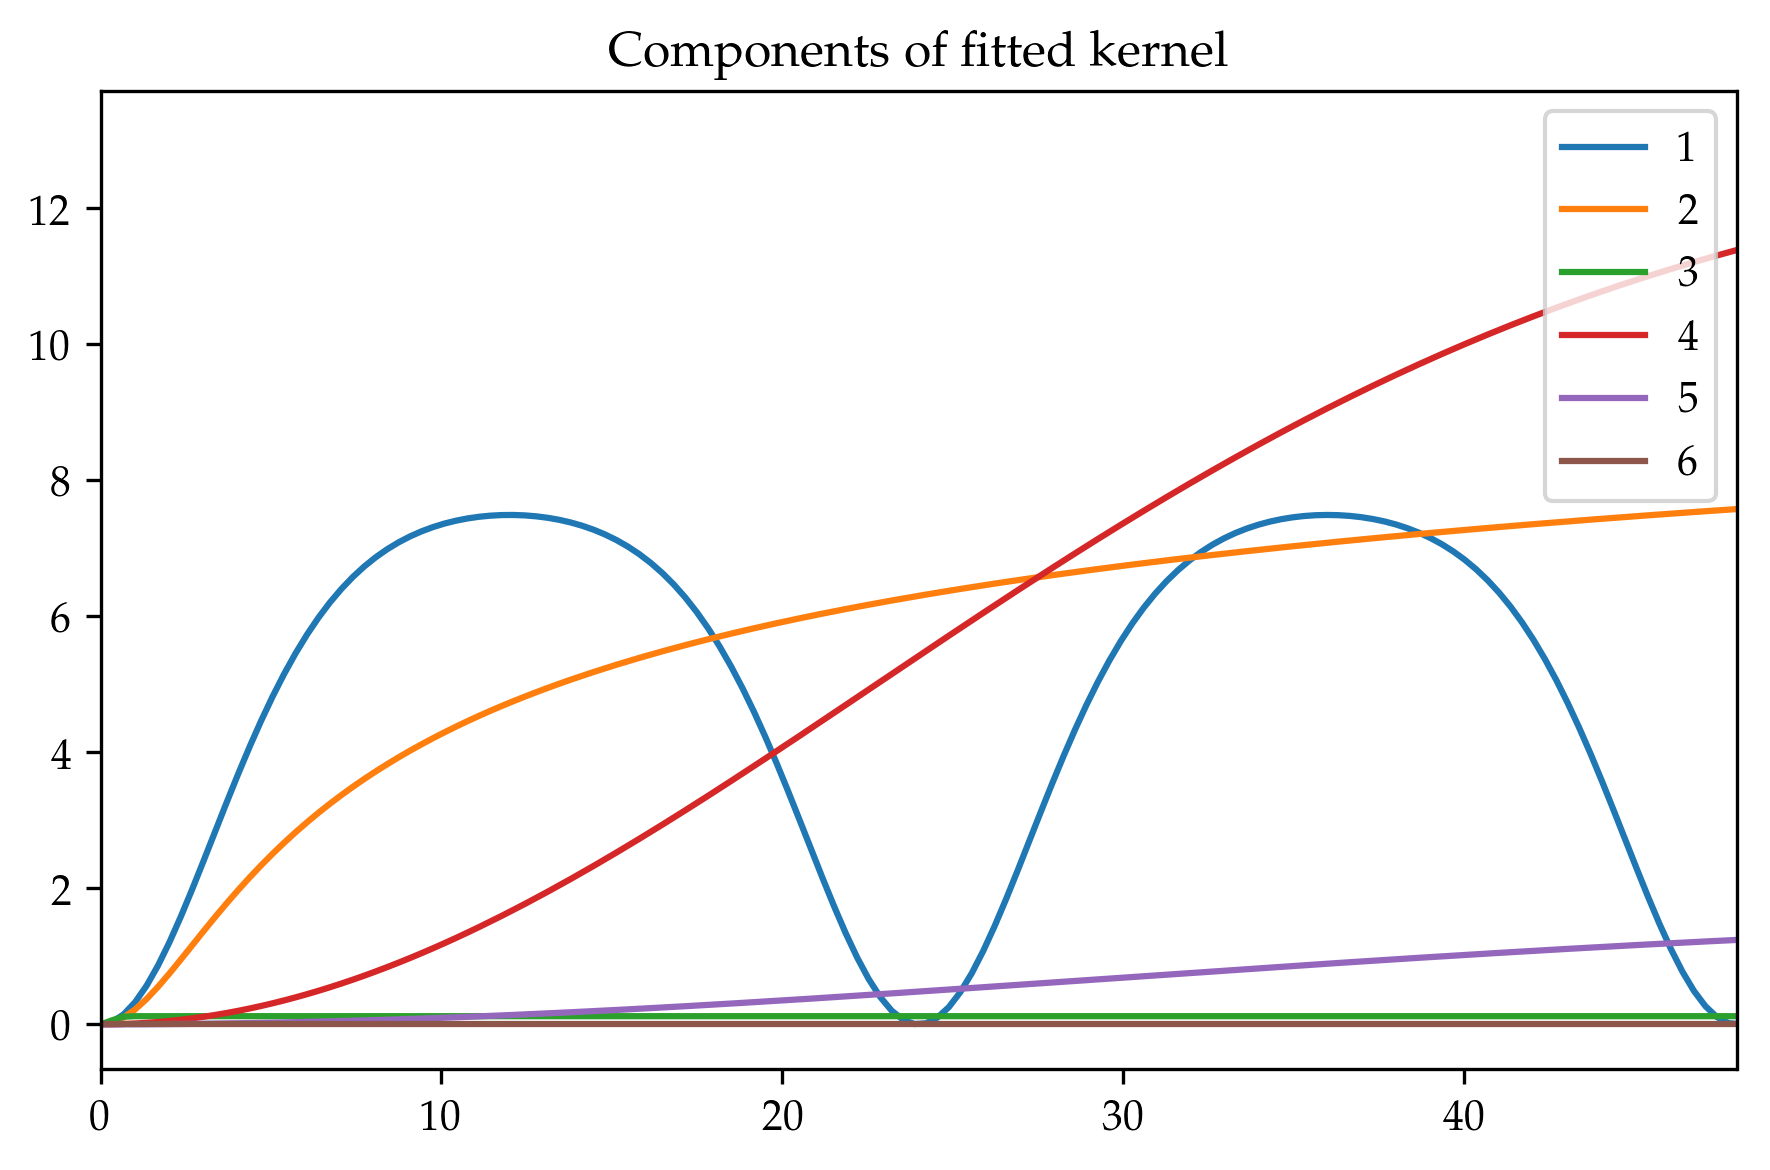

In [25]:
begin
    rr = linspace(0.0, 24*14, 1000)
    for (i,k) in enumerate(_k_nonoise.kerns)
        cki_r = [cov(k, [r], [0.0]) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, label=string(i));
    end
    plt.xlim(0,24*2)
    plt.legend(loc="upper right")
    plt.title("Components of fitted kernel")
end
;

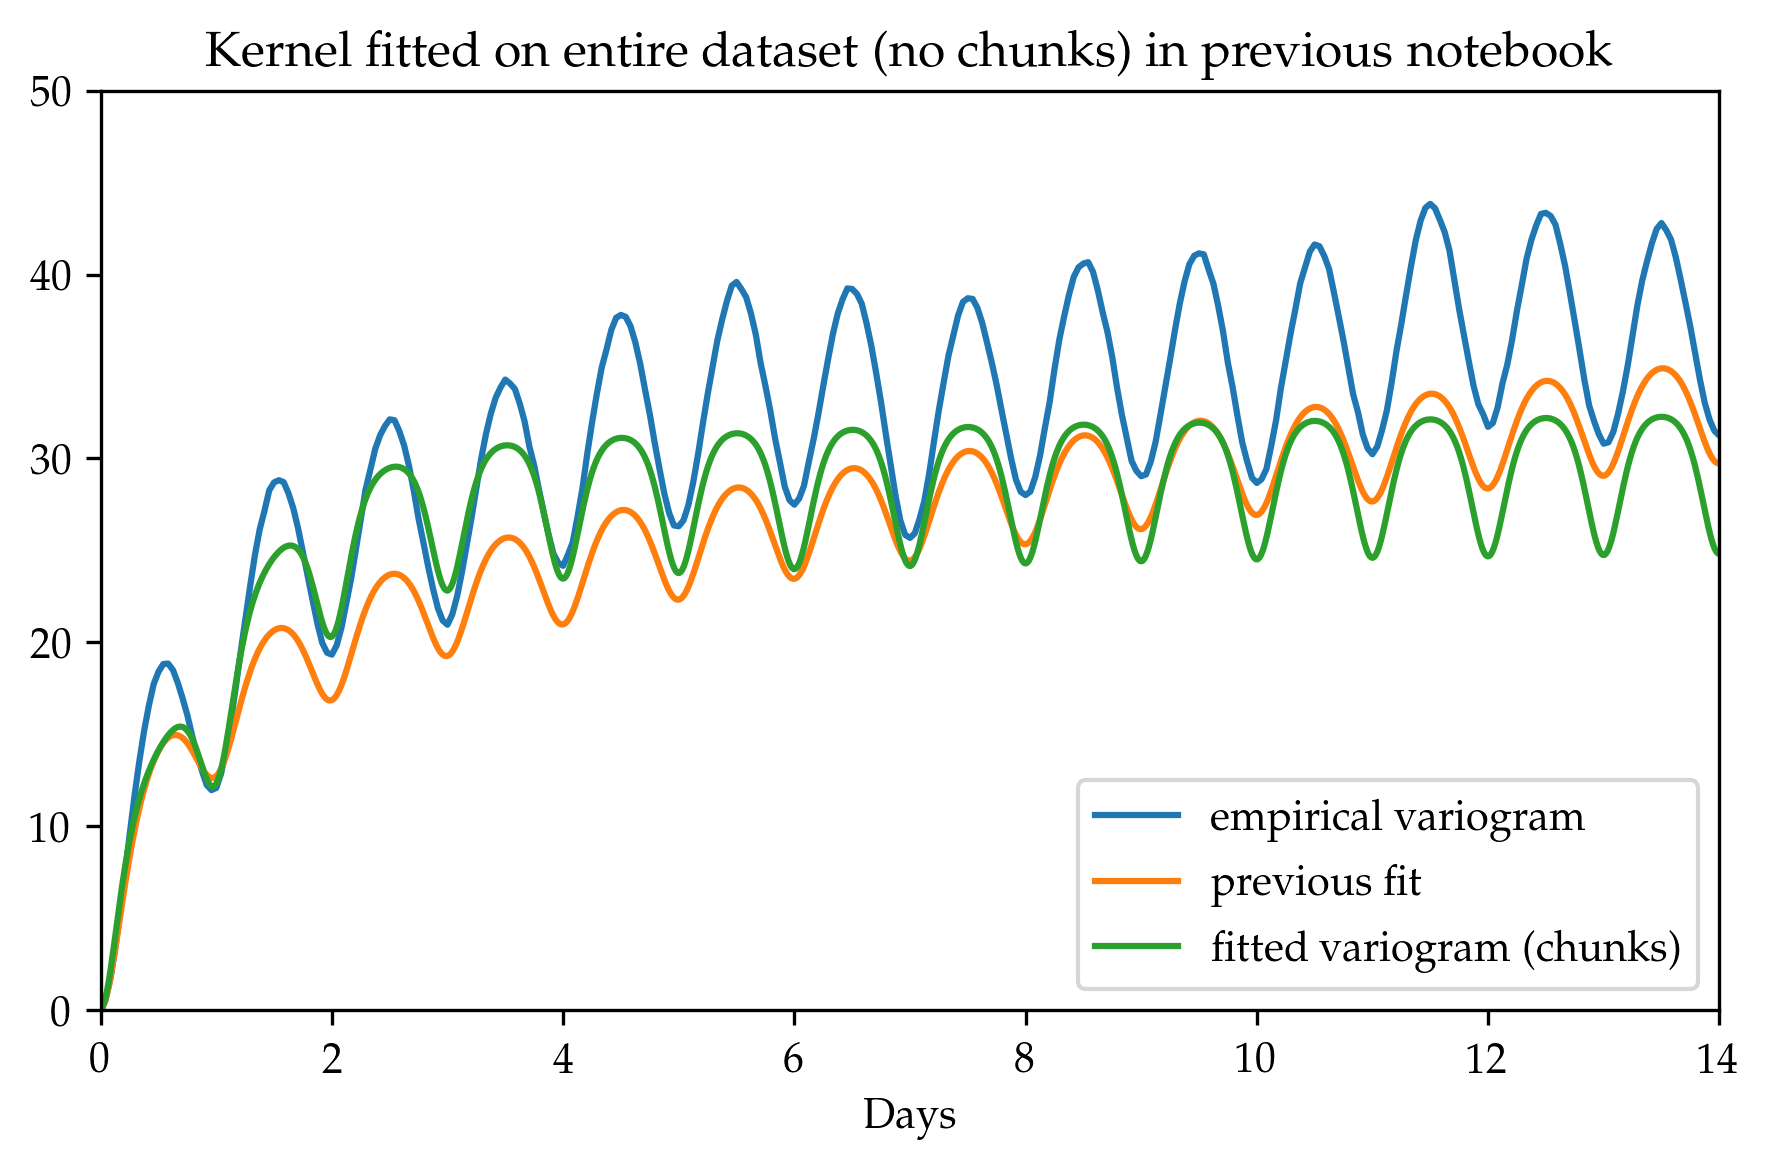

In [26]:
begin
    bins_hours = Float64.(_bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, label="empirical variogram")
    __k0 = Noise(0.0)
    __k1 = fix(Periodic(log(0.5), log(√(10.0)), log(24.0)), :lp)
    __k2 = RQIso(log(0.1*24), log(√10.0), 3.0) # short term
    __k3 = RQIso(log(3.0*24), log(√20.0), 3.0)
    __k4 = RQIso(log(10.0*24), log(√20.0), 3.0)
    __k5 = SE(log(200.0*24), log(√80.0))
    __k_nonoise=__k1+__k2+__k3+__k4+__k5
    set_params!(__k_nonoise, hyp_nonoise[3:end] )
    rr = linspace(0.0, 24*14, 1000)
    _ck_r = [cov(__k_nonoise, r) for r in rr]
    plt.plot(rr/24, _ck_r[1]-_ck_r, label="previous fit")
    
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24, ck_r[1].-ck_r, label="fitted variogram (chunks)")
    
    plt.xlim(0,14)
    plt.ylim(0,50)
    plt.xlabel("Days")
    plt.legend(loc="lower right")
    plt.title("Kernel fitted on entire dataset (no chunks) in previous notebook")
end
;

Looking at the variograms, the fit is pretty close, though I had hoped for an even closer match, given the flexibility of the kernel. In particular, the amplitude of the periodic component clearly looks too small. It's possible that the model is trading off fitting short-term correlations very well, at the expense of the diurnal and longer components.

# Simulations from prior

It's worth also simulating a few time series from the prior with the kernel hyperparameters as fitted above. Visually comparing this to the real data, we can check that they look similar, in terms of amplitude and timescales of temperature changes.

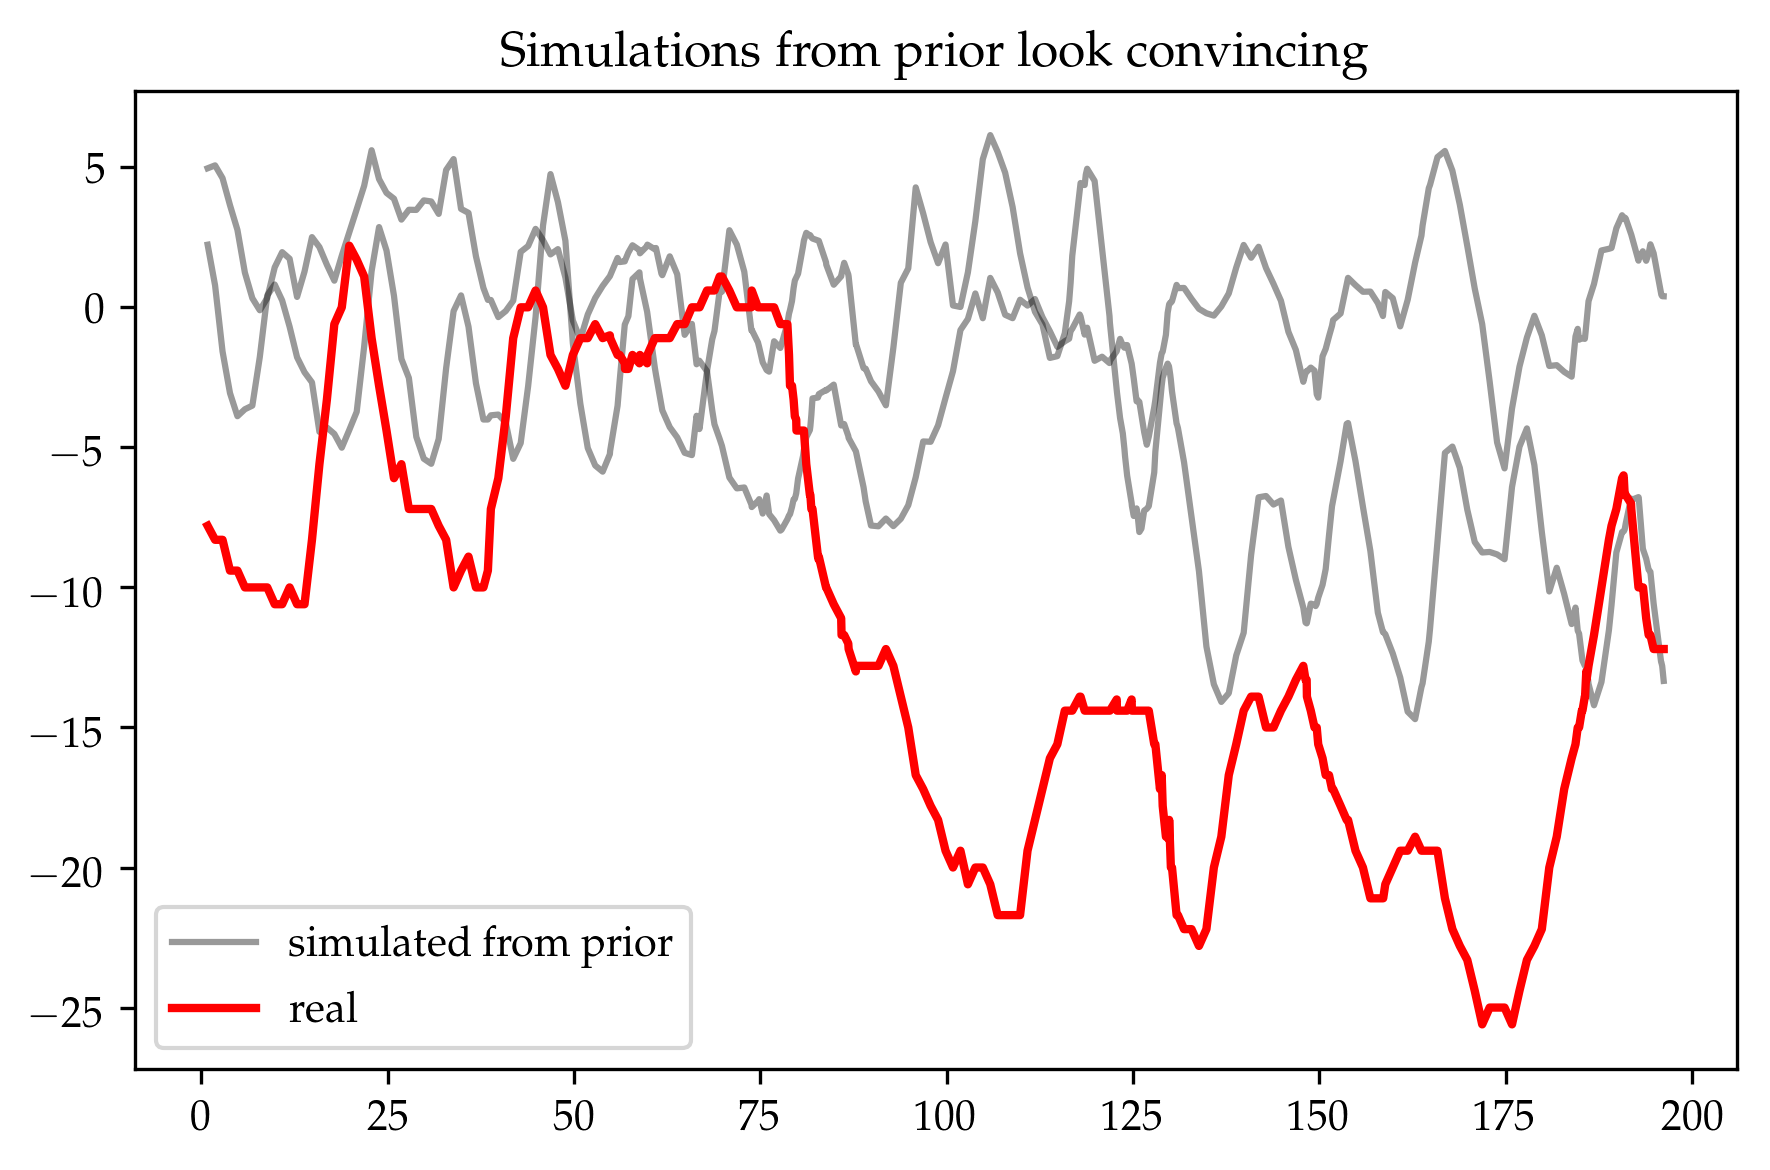

In [27]:
begin 
    gp_prior = GPE(zeros(1,0), zeros(0), MeanConst(0.0), _k_nonoise, _gpr.logNoise)
    gp = _gpr.reals[1]
    x = gp.X
    plt.plot(vec(x), rand(gp_prior, x), color="black", alpha=0.4, label="simulated from prior")
    plt.plot(vec(x), rand(gp_prior, x), color="black", alpha=0.4)
    plt.plot(vec(x), gp.y, color="red", linewidth=2, label="real")
    plt.legend()
    plt.title("Simulations from prior look convincing")
end
;

## Variogram simulations

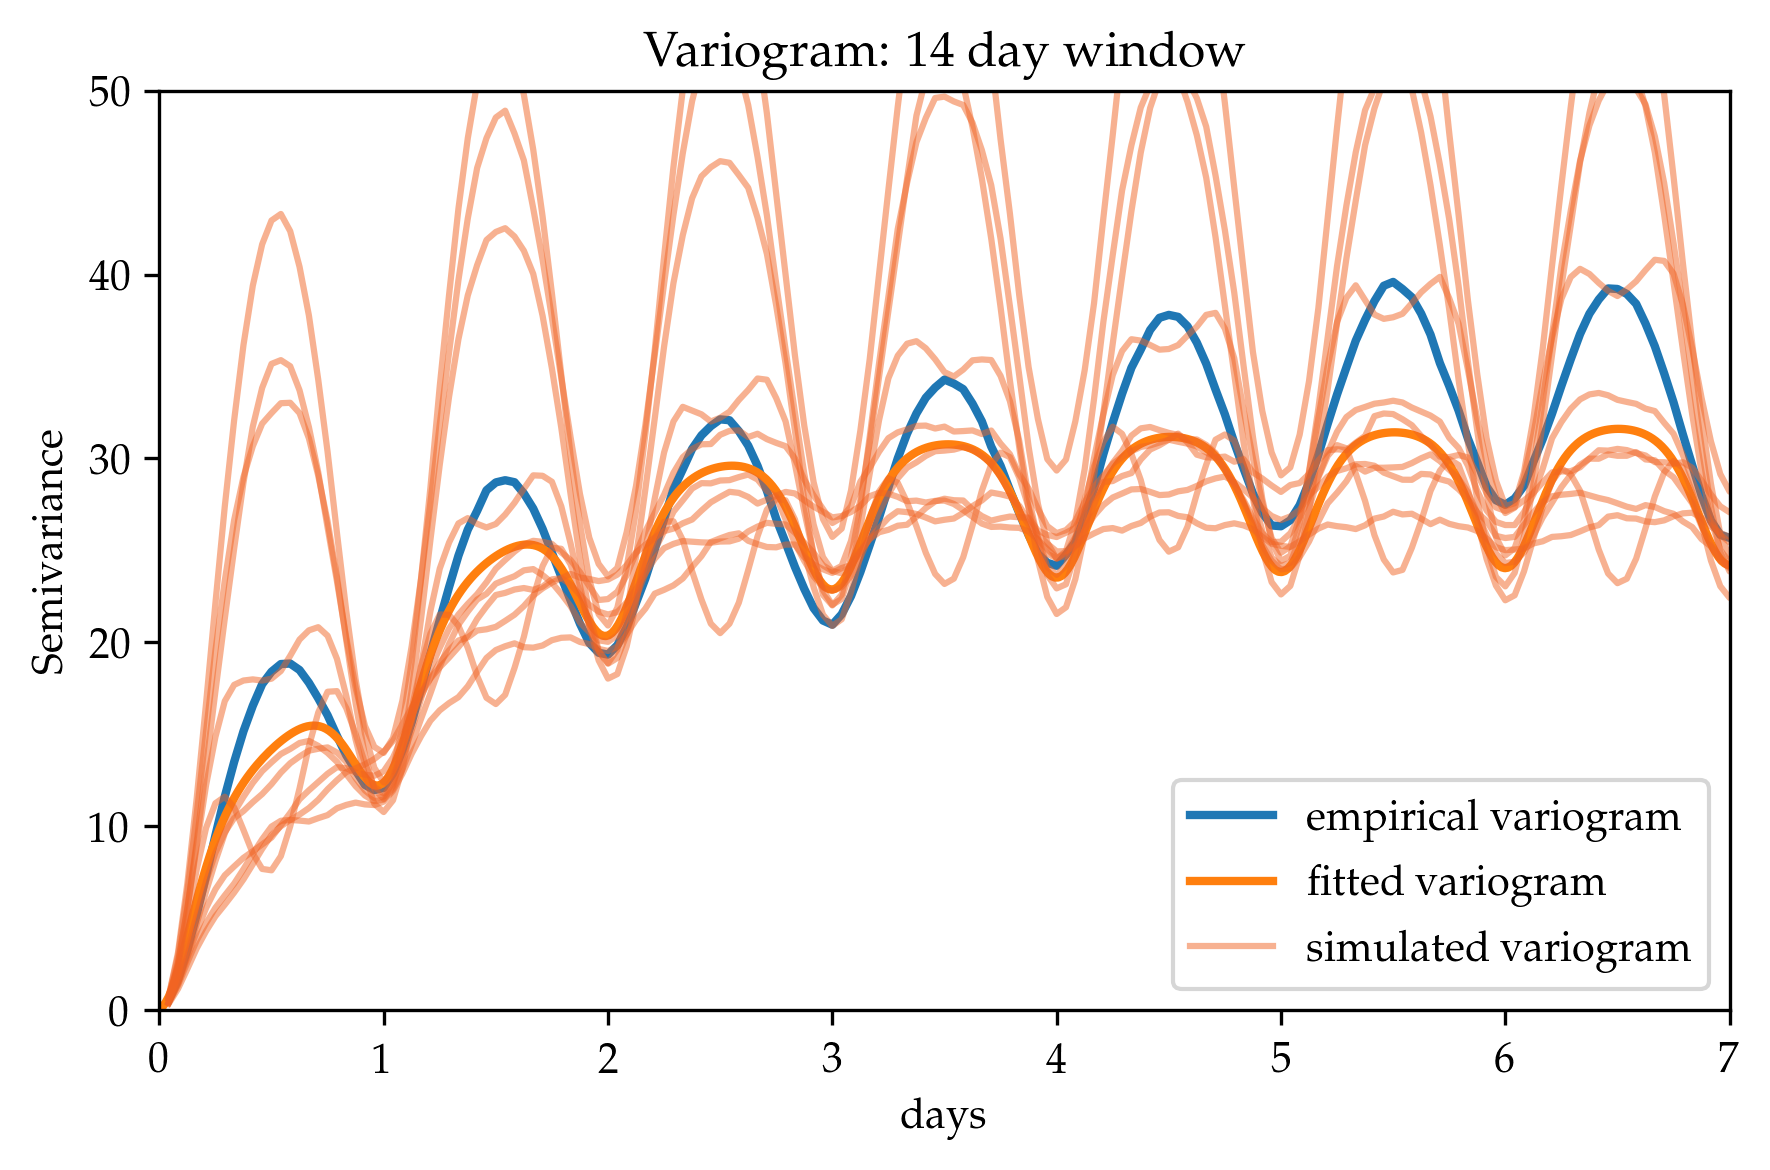

In [28]:
begin 
    bins_hours = Float64.(_bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, linewidth=2, label="empirical variogram")
    plt.ylim(0,50)
    plt.xlim(0,7)
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24.0, exp(2.0*_gpr.logNoise)+ck_r[1].-ck_r, linewidth=2, label="fitted variogram")
    
    for s in 1:10
        gp_prior = GPE(zeros(1,0), zeros(0), MeanConst(0.0), _k_nonoise, _gpr.logNoise)
        simul1 = rand(gp_prior, ts_vec')
        simul_variog = TempModel.variog(
            TempModel.timeseries_variogram(ts_vec, simul1, _bins)
            )
        label = s==1 ? "simulated variogram" : ""
        plt.plot(bins_days, simul_variog, color="#F16424", alpha=0.5, label=label)
    end
    plt.legend(loc="lower right")
    plt.xlabel("days")
    plt.ylabel("Semivariance")
    plt.title("Variogram: 14 day window")
end
;

# Understanding the periodic kernel

It looks to be like the periodic component's amplitude is too small in our fitted model. My intuition is that $\GP$s care more about fitting short-term correlations than long-term correlations (the opposite of a human fitting a variogram by eye). In the 24hr plot, it looks like the fitted variogram is overshooting its empirical counterpart slightly at $\Delta t= 2$ hours, and looking at the individual components of the fitted kernel, it's clear that this is driven by the period kernel. Therefore the fitted model might be choosing a reduced amplitude in order to reduce this discrepancy at low lags. What we want is a periodic kernel that is flatter at short lags. Let's explore our options.

In [29]:
# Reminder of the fitted periodic kernel
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.kern.σ2)
@printf("l: %5.3f\n", √k1.kern.ℓ2)
@printf("p: %5.0f hours\n", k1.kern.p)

k₁: Periodic 
σ: 2.885
l: 0.933
p:    24 hours


The periodic kernel I'm using here has three parameters ($\sigma$, $\l$ and $p$) and is defined as:
$$k(t,t') = \sigma^2 \exp\del{ - \frac{2}{\l^2} \sin^2(\pi (t-t') / p)}$$
Let's visually explore what the $\l$ parameter does.

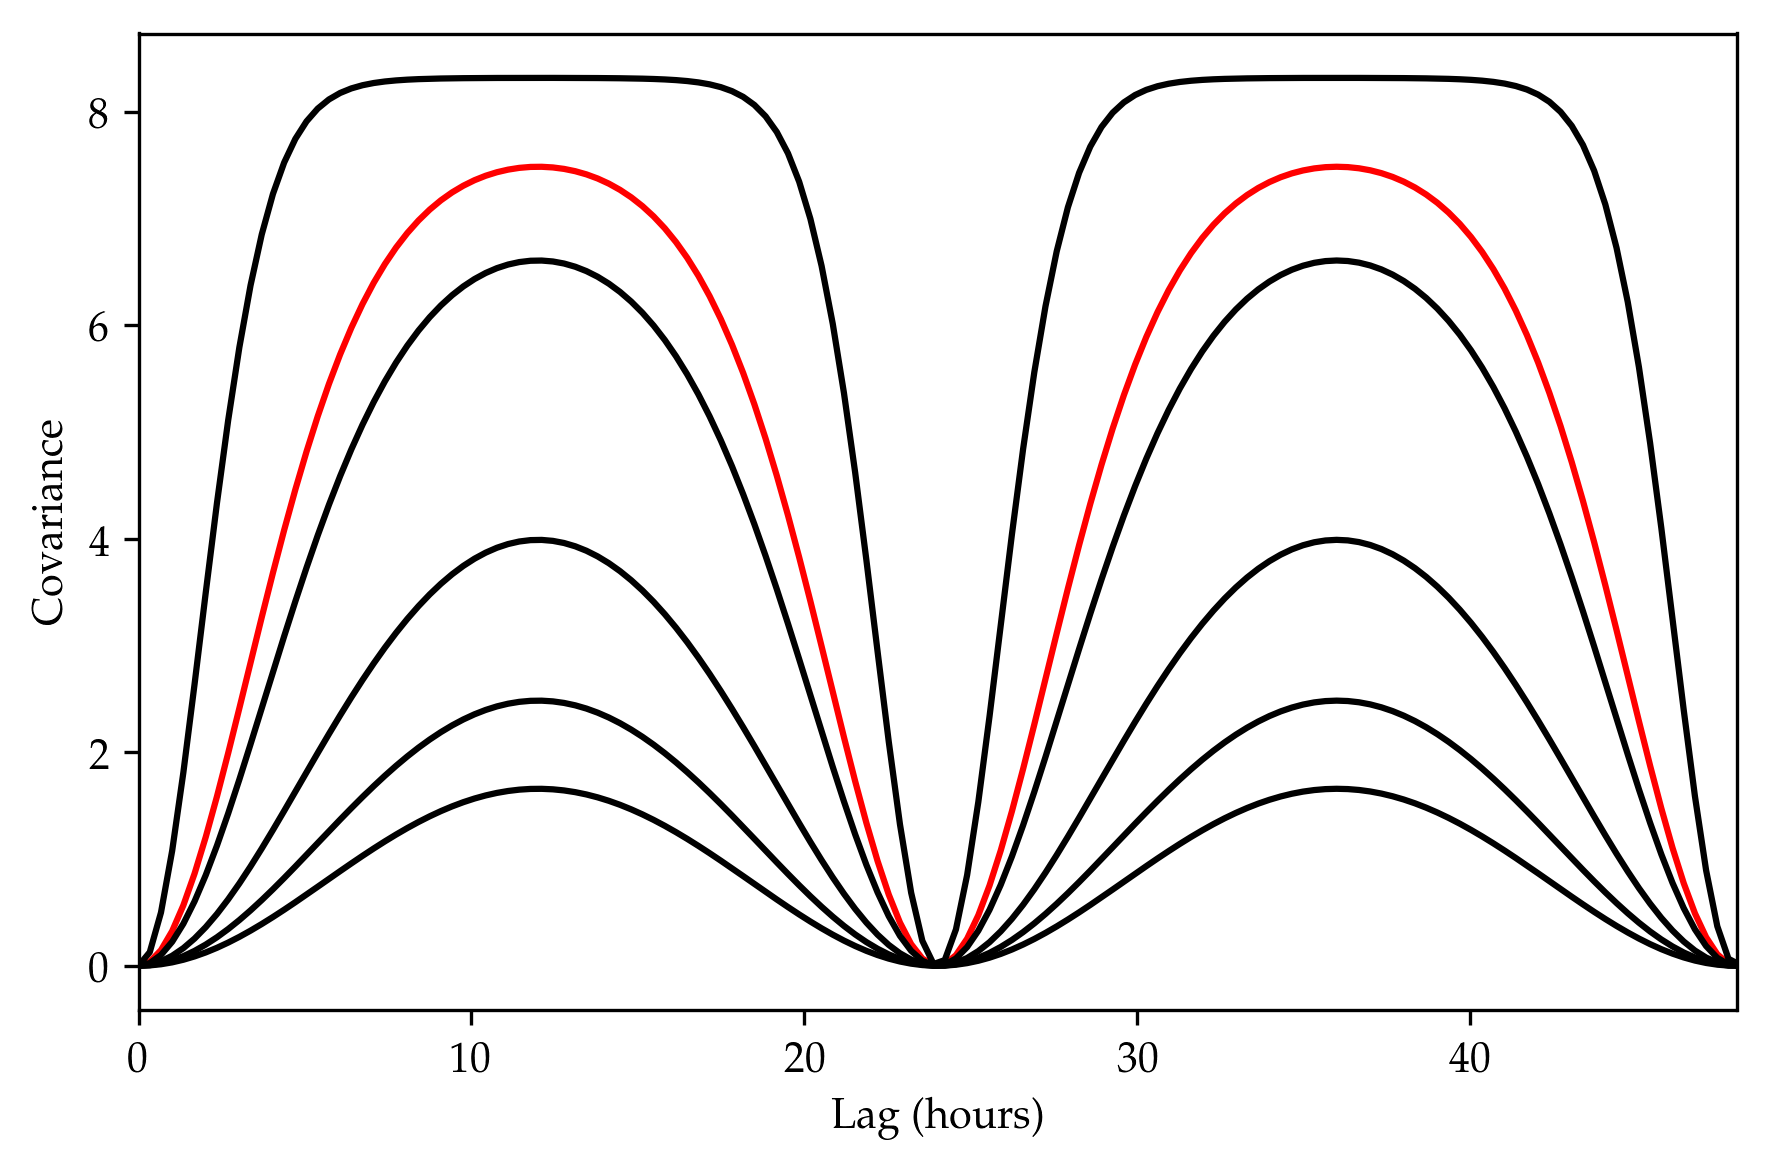

In [30]:
begin
    k1_free = GaussianProcesses.free(k1)
    cki_r = [cov(k1_free, [r], [0.0]) for r in rr]
    plt.plot(rr, cki_r[1]-cki_r, color="red")
    for 𝓁 in linspace(0.5,3.0,5)
        k = Periodic(log(𝓁), log(k1_free.σ2)/2.0, log(k1_free.p))
        cki_r = [cov(k, [r], [0.0]) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, color="black")
    end
end
plt.ylabel("Covariance")
plt.xlabel("Lag (hours)")
plt.xlim(0,24*2)
;

So, shorter $\l$ values correspond to a steeper rise in the variogram. But the effect is confusing because it also affects the amplitude of the kernel. Let's reparametrize the kernel and keep it constant.

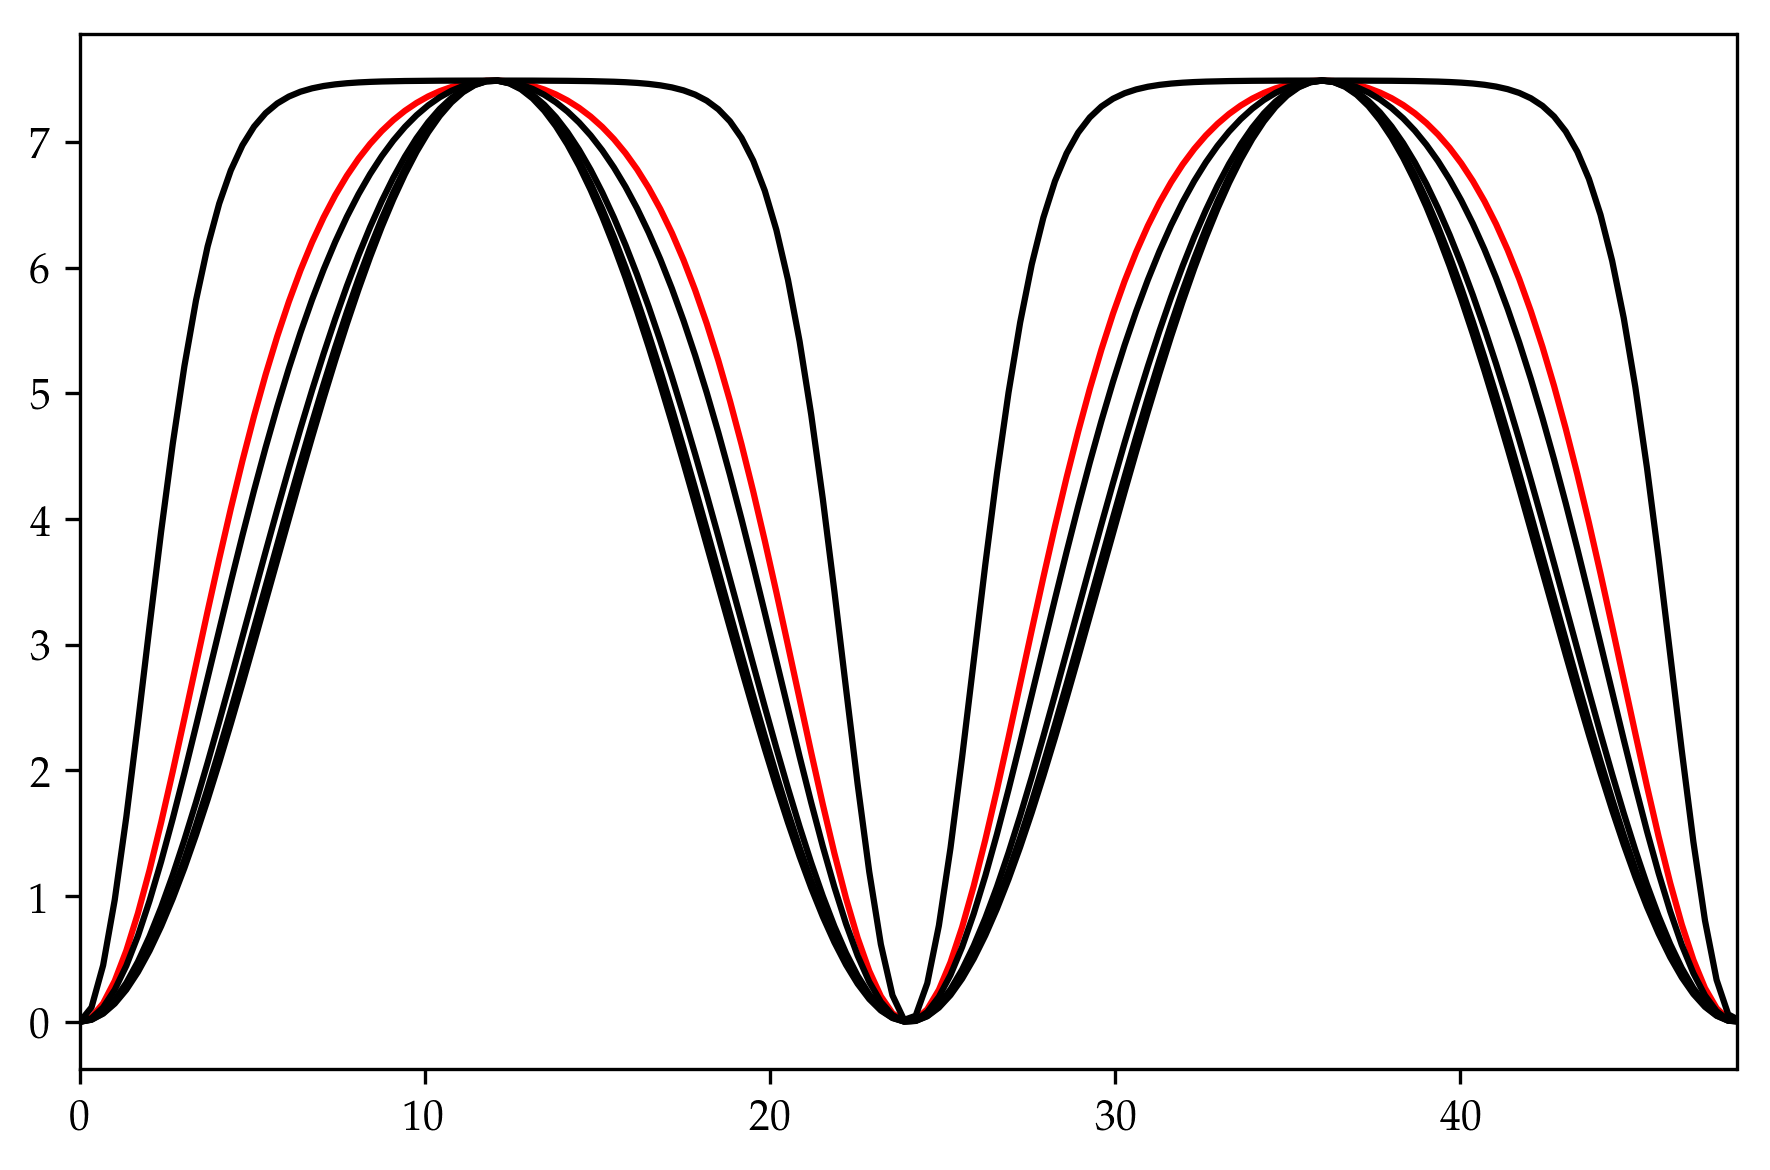

In [31]:
begin
    k1_free = GaussianProcesses.free(k1)
    rr = linspace(0.0, 24*14, 1000)
    cki_r = [cov(k1_free, [r], [0.0]) for r in rr]
    target_max = k1_free.σ2-cov(k1, [12.0], [0.0])
    plt.plot(rr, cki_r[1]-cki_r, color="red")
    for 𝓁 in linspace(0.5,3.0,5)
        k = Periodic(log(𝓁), 0.0, log(k1_free.p))
        max_ck = 1.0-cov(k, evaluate(metric(k), [12.0], [0.0]))
        k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, log(k1_free.p))
        cki_r = [cov(k_scaled, evaluate(metric(k_scaled), [r], [0.0])) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, color="black")
    end
    plt.xlim(0,24*2);
end
;

So we can adjust how steeply the kernel rises while keeping the amplitude constant. This is confusing because it seems like the optimization should therefore have chosen a kernel with a longer lengthscale and higher $\sigma^2$, to better fit the empirical variogram. Let's see if we can fit the empirical variogram, and check that the marginal likelihood goes down, to make sure it isn't the optimization failing.

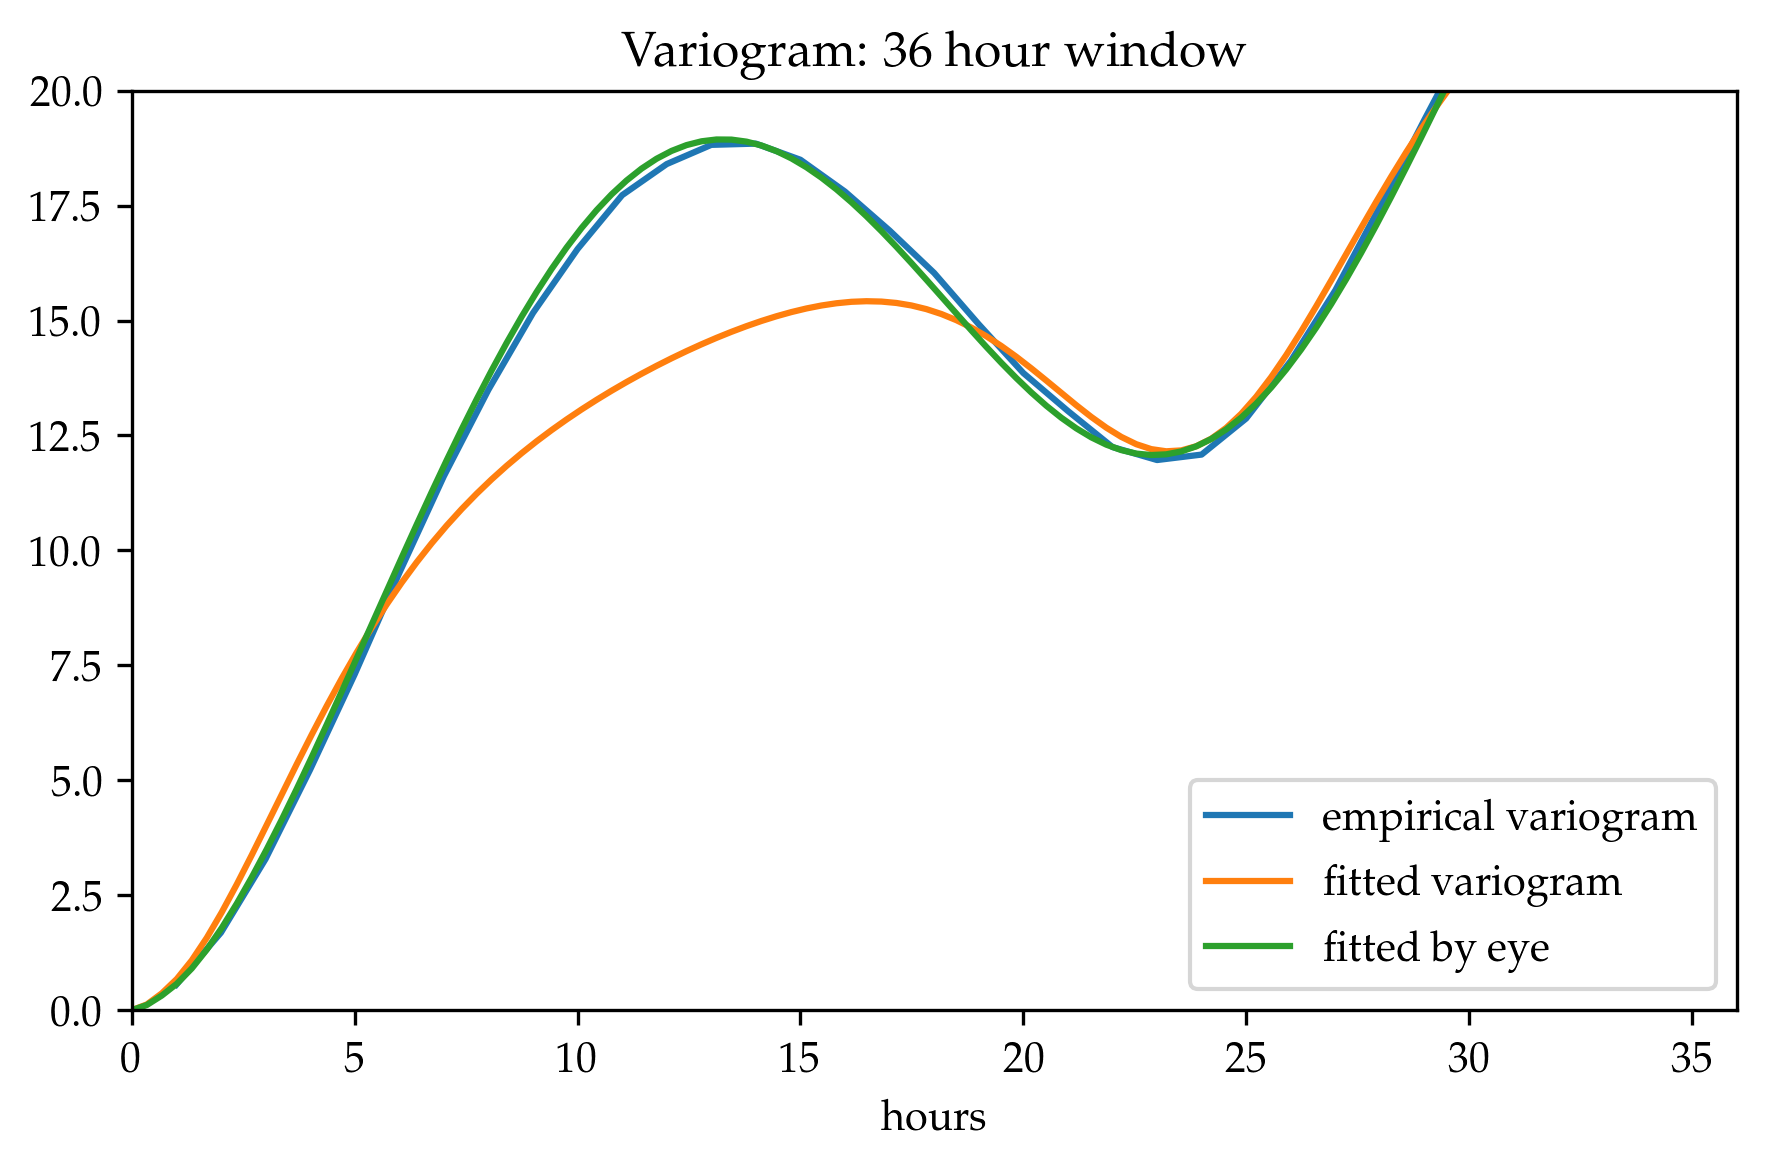

In [32]:
begin
    k1_free = GaussianProcesses.free(k1)
    lp = get_params(k1_free)[end]
    target_max = 12.0 # by eye
    rr = linspace(0.0, 24*14, 1000)
    𝓁 = 4.0
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    k = Periodic(log(𝓁), 0.0, lp)
    max_ck = 1.0-cov(k, [12.0], [0.0])
    k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, lp)
    my_sumkernel = k_scaled + k2 + k3 + k4 + k5 + k6
    plt.plot(bins_hours, station_variog, label="empirical variogram")
    rr = linspace(0.0, 24*14, 1000)
    ck_r_mine = [cov(my_sumkernel, r) for r in rr]
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr, ck_r[1].-ck_r, label="fitted variogram")
    plt.plot(rr, ck_r_mine[1].-ck_r_mine, label="fitted by eye")
    plt.legend(loc="lower right")
    plt.xlabel("hours")
    plt.ylim(0,20)
    plt.xlim(0,36)
    plt.title("Variogram: 36 hour window")
end
;

In [33]:
begin
    k1_free = GaussianProcesses.free(k1)
    lp = get_params(k1_free)[end]
    target_max = 12.0 # by eye
    𝓁 = 4.0
    k = Periodic(log(𝓁), 0.0, lp)
    max_ck = 1.0-cov(k, [12.0], [0.0])
    k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, lp)
    my_sumkernel = k_scaled + k2 + k3 + k4 + k5 + k6
    gprealisations=GPE[]
    istart=1
    while istart < length(ts_vec)
        iend = min(istart+chunksize-1, length(ts_vec))
        x = ts_vec[istart:iend]
        y = temp_vec[istart:iend]
        m = MeanConst(mean(y))
        gp = GP(x, y, m, my_sumkernel, _gpr.logNoise);
        push!(gprealisations, gp)
        istart+=chunksize
    end
    @printf("mLL optimized kernel: %.1f\n", _gpr.mll)
    my_gpr = TempModel.GPRealisations(gprealisations, _meanfunc, my_sumkernel, _gpr.logNoise, 0.0, Float64[])
    update_mll!(my_gpr)
    @printf("mLL eye-fitted kernel: %.1f\n", my_gpr.mll)
    TempModel.optimize!(my_gpr, noise=true, domean=false, kern=false, options=Optim.Options(x_tol=1e-5, f_tol=1e-10))
    @printf("mLL after optimizing logNoise: %.1f\n", my_gpr.mll)
    TempModel.optimize!(my_gpr, domean=false, options=Optim.Options(x_tol=1e-5, f_tol=1e-10))
    @printf("mLL after optimizing kernel: %.1f\n", my_gpr.mll)
end
;

mLL optimized kernel: -12485.0
mLL eye-fitted kernel: -12680.8
mLL after optimizing logNoise: -12680.4
mLL after optimizing kernel: -12485.2


OK so this is clearly not a good idea! I don't know why the log-likelihood degrades significantly with a kernel that fits the empirical variogram so much better! To summarize what we've seen:
* The periodic component of the kernel obtained by optimization of the marginal likelihood has a lower magnitude than what can be seen in the empirical variogram.
* At first I though maybe the periodic kernel isn't flexible enough to fit the corelation structure for measurements a small duration away from each other.
* But I was able to manually find parameters that fit the variogram much better.
* However, the kernel that fits the variogram better has a much worse marginal likelihood
* I don't know why this is the case.
* In spatial statistics, fitting the variogram is considered less good (statistically) than optimizing the marginal likelihood. Therefore, I prefer to trust the kernel obtained through likelihood optimization.